# **Solution to PSet 2**

> provided and graded by Andy Chu

[:material-download: Download this notebook](./sol2.ipynb)

In [1]:
# Import required libraries
import numpy as np
from math import ceil
import matplotlib.pyplot as plt
from IPython.display import display, Latex
from datetime import datetime
from pytz import timezone

# Install and import QuTiP if needed
try:
    from qutip import *
except ImportError:
    %pip install qutip
    from qutip import *

# Configure matplotlib for LaTeX rendering
plt.rcParams.update(
    {
        "text.usetex": True,
        "text.latex.preamble": r"\usepackage{amsmath} \usepackage{physics}",
        "font.family": "serif",
    }
)
%config InlineBackend.figure_format = 'svg'

# Print version and execution time info
print(f"QuTiP version: {qutip.__version__}")
print(
    "Time of execution: ",
    datetime.now(timezone("America/Chicago")).strftime("%Y-%m-%d %H:%M:%S"),
)

QuTiP version: 5.1.1
Time of execution:  2025-04-11 13:16:23


## **Problem 2-1 [45 points + 2 points for nice code and plotting style]**

Here you will simulate spin dynamics in QuTiP; please submit a Jupyter notebook via Canvas for this problem. In an experiment, you have a $B_0 = 1 \mathrm T$ magnetic field oriented along the $\hat{z}$ direction and an oscillating magnetic field with $\sin(\omega t) B_x \hat{x}$, with $B_x = 0.2 \mathrm{mT}$ and a frequency $\omega$ that is under your control.

### **a.  [5 points]**  
Express the Hamiltonian $H/\hbar$ in an appropriate rotating frame and insert it in QuTiP.

---

In [2]:
# Physical constants
gamma = 2*np.pi*28025  # MHz/T for electron gyromagnetic ratio
# gamma = 2*np.pi*42.58  # MHz/T for proton gyromagnetic ratio if you wanna use proton
B0 = 1.0               # Tesla (static z-field)
Bx = 0.0002            # Tesla (oscillating x-field amplitude)

# Calculate derived quantities
omega0 = gamma * B0    # Natural Larmor frequency (MHz)
Omega = gamma * Bx     # Rabi frequency (MHz)

def get_hamiltonian(Delta):
    """
    Generate Hamiltonian in the rotating frame for a given detuning.
    
    In the rotating frame, the Hamiltonian becomes:
    H/ħ = -Δ/2 * σz - Ω/2 * σx
    
    Parameters:
        Delta (float): Detuning (ω0 - ω) in MHz
        
    Returns:
        Qobj: QuTiP operator representing the Hamiltonian
    """
    return -Delta/2 * sigmaz() - Omega/2 * sigmax()

# Display example Hamiltonians
H_resonance = get_hamiltonian(0)
print("Hamiltonian at resonance:")
print(H_resonance)

# Example with positive detuning
Delta_pos = 10  # MHz
H_off_resonance = get_hamiltonian(Delta_pos)
print("\nHamiltonian with positive detuning:")
print(H_off_resonance)

Hamiltonian at resonance:
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[  0.         -17.60862682]
 [-17.60862682   0.        ]]

Hamiltonian with positive detuning:
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ -5.         -17.60862682]
 [-17.60862682   5.        ]]


**[Rotating Wave Approximation]**

**framework:**

-   $H(t)$ is still an arbitrary Hamiltonian, but now it could be time-dependent.<br/>(It's called the Hamiltonian in the interaction picture.)

-   Introduce a rotating frame-related quantity $T(t) = e^{iAt}$, here $A$ is time-independent and Hermitian.

Now we want to transform from the resting frame into the “rotating frame” (which is characterized by $A$), and the logic is:

$$
\begin{align*}
    i\frac{∂}{∂t} \ket\psi &= H(t) \ket\psi \\
    i\frac{∂}{∂t} (T\ket\psi) &= H_I(t)(T\ket\psi), \\
    \ket\psi &\mapsto T\ket\psi \\
    H(t) &\mapsto H_I(t).
\end{align*}
$$

How do we express $H_I(t)$ in terms of the original $H(t)$ and $T$?<br/>Notice that:

$$
\begin{align*}
    (THT^\dagger)(T\ket\psi) &= TH(T^\dagger T\ket\psi) \\
    &= T i\frac{∂}{∂t}(T^\dagger T\ket\psi) \\
    &= T i\left[ \frac{∂T^\dagger}{∂t}\cdot (T\ket\psi) + T^\dagger\cdot\frac{∂}{∂t}(T\ket\psi) \right] \\
    &= iT\frac{∂T^\dagger}{∂t} \cdot (T\ket\psi) + i \frac{∂}{∂t}(T\ket\psi) \\
    \implies H_I(t) &= (THT^\dagger) - iT\frac{∂T^\dagger}{∂t}
\end{align*}
$$

**application to RWA:**

Following the previous definitions for $H$, $A$ and $T$, one specific case that's considered widely is

$$
\begin{cases}
    &H = \boxed{\alpha H_0} + H_1 = \boxed{\frac{\omega_0}{2}\sigma_z} + \Omega\cos(\omega t + \phi)\sigma_x \\
    &A = \boxed{\beta H_0} = \boxed{\frac{\omega}{2}\sigma_z}
\end{cases}
$$

<small>often we consider the case where $\omega\gg\Omega$ and $\omega\gg|\omega-\omega_0|$.</small>

Then, according to the changing rule for $H(t) \mapsto H_I(t)$ that we just derived above,

$$
\begin{align*}
    H_I(t) 
    &= (THT^\dagger) - iT\frac{∂T^\dagger}{∂t} \\
    &= e^{iAt} (\alpha H_0 + H_1) e^{-iAt} - ie^{iAt}\frac{∂e^{-iAt}}{∂t} \\
    &= \boxed{e^{iAt} (\alpha H_0) e^{-iAt}} + e^{iAt} (H_1) e^{-iAt} - A \\
    &= \boxed{(\alpha H_0)} + e^{iAt} (\Omega\cos(\omega t + \phi)\sigma_x) e^{-iAt} - A \\
    &= \frac{\omega_0}{2}\sigma_z + \Omega\cos(\omega t + \phi) e^{i\omega\sigma_zt/2} \sigma_x e^{-i\omega\sigma_zt/2} - \frac{\omega}{2}\sigma_z \\
    &= \frac{\omega_0-\omega}{2}\sigma_z + \Omega\cos(\omega t + \phi)
        \begin{bmatrix}
           e^{i\omega t/2} & 0 \\
           0 & e^{-i\omega t/2}
        \end{bmatrix}
        \begin{bmatrix}
           0 & 1 \\
           1 & 0
        \end{bmatrix}
        \begin{bmatrix}
           e^{-i\omega t/2} & 0 \\
           0 & e^{i\omega t/2}
        \end{bmatrix} \\
    &= \frac{\omega_0-\omega}{2}\sigma_z + \Omega\cos(\omega t + \phi)
        \begin{bmatrix}
           0 & e^{i\omega t} \\
           e^{-i\omega t} & 0
        \end{bmatrix} \\
    &= \frac{\omega_0-\omega}{2}\sigma_z + \frac\Omega 2
        \begin{bmatrix}
           0 & \textcolor{red}{e^{2i\omega t+i\phi}} + e^{-i\phi} \\
           e^{i\phi} + \textcolor{red}{e^{-2i\omega t-i\phi}} & 0
        \end{bmatrix}
\end{align*}
$$

<small>(note that the boxed $\boxed{e^{iAt} (\alpha H_0) e^{-iAt}}$ term can be reduced to $\boxed{(\alpha H_0)}$ because all terms only involve $\sigma_z$​, hence commute with each other.)</small>

We can ignore the term $\textcolor{red}{\cancel{e^{2i\omega t+i\phi}}}$ and $\textcolor{red}{\cancel{e^{-2i\omega t-i\phi}}}$ if we are only interested in the system's long-time behavior, and this leads to:

$$
H_I(t) \approx \frac{\omega_0-\omega}{2}\sigma_z + \frac\Omega 2 (\sigma_x\cos\phi + \sigma_y\sin\phi),
$$

which is the effective Hamiltonian in the rotating frame $(\omega)$.

### **b.  [5 points]**  
Plot the energy spectrum (i.e. the eigenenergies) as a function of detuning $\Delta = \omega_0 - \omega$, where $\omega_0$ is the spin precession frequency in $B_0$. Make sure that your axes are labeled and have units. Compare with the case where $B_x = 0$.

---

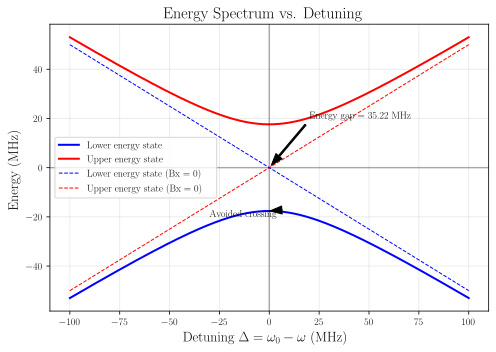

In [3]:
# Calculate eigenenergies as a function of detuning
detunings = np.linspace(-100, 100, 1000)  # Range of detunings in MHz

# Vectorize calculation of eigenenergies
def calculate_eigenenergies(Delta, Omega):
    """Analytical formula for eigenenergies of 2-level system with detuning and driving"""
    return np.array([
        -0.5 * np.sqrt(Delta**2 + Omega**2),
        0.5 * np.sqrt(Delta**2 + Omega**2)
    ])

# Calculate eigenenergies using vectorized approach
eigenenergies = np.array([calculate_eigenenergies(Delta, Omega) for Delta in detunings])

# Plot the energy spectrum
plt.figure(figsize=(7, 5))

# Plot eigenenergies with driving (Bx ≠ 0)
plt.plot(detunings, eigenenergies[:, 0], "b-", linewidth=2, label="Lower energy state")
plt.plot(detunings, eigenenergies[:, 1], "r-", linewidth=2, label="Upper energy state")

# Plot eigenenergies without driving (Bx = 0)
plt.plot(detunings, -detunings/2, "b--", linewidth=1, label="Lower energy state (Bx = 0)")
plt.plot(detunings, detunings/2, "r--", linewidth=1, label="Upper energy state (Bx = 0)")

# Add annotations
plt.annotate("Avoided crossing", xy=(0, -Omega/2), xytext=(-30, -20),
             arrowprops=dict(facecolor="black", shrink=0.05, width=1.5, headwidth=8))

plt.annotate(f"Energy gap = {Omega:.2f} MHz", xy=(0, 0), xytext=(20, 20),
             arrowprops=dict(facecolor="black", shrink=0.05, width=1.5, headwidth=8))

# Add grid and reference lines
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.axvline(x=0, color="k", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)

# Labels and formatting
plt.xlabel(r"Detuning $\Delta = \omega_0 - \omega$ (MHz)", fontsize=14)
plt.ylabel(r"Energy (MHz)", fontsize=14)
plt.title(r"Energy Spectrum vs. Detuning", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


### **c.  [5 points]**  
What are the eigenvectors for positive and negative detuning, and for on-resonance driving.  Compare these to the bare eigenstates without the driving field.  This can be calculated done analytically or numerically. Please discuss the result.

---

The eigenstates on resonance are: 
[Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.70710678]
  [-0.70710678]]
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.70710678]
  [ 0.70710678]]                                                       ]
--------------------
The eigenstates for positive detuning are: 
[Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.79785751]
  [-0.60284608]]
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.60284608]
  [ 0.79785751]]                                                       ]
--------------------
The eigenstates for negative detuning are: 
[Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.60284608]
  [-0.79785751]]
 Quantum object: dims=[[2], [1]], shape=(2, 1), type='ket', dtype=Dense
 Qobj data =
 [[-0.79785751]
  [ 0.60284608]]                

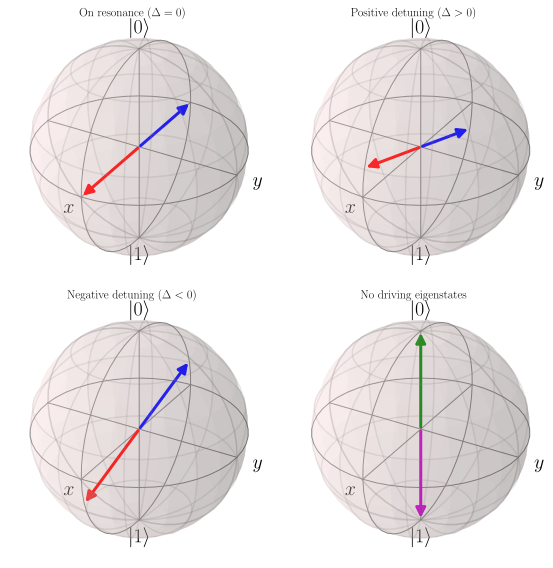

In [4]:
# Define the detuning values for analysis
Delta_values = [0, 10, -10]  # MHz: resonant, positive, negative
titles = [r'On resonance ($\Delta = 0$)', r'Positive detuning ($\Delta > 0$)', r'Negative detuning ($\Delta < 0$)', 'No driving eigenstates']

# Calculate and display eigenstates
hamiltonians = [get_hamiltonian(Delta) for Delta in Delta_values]
eigenstates_list = [H.eigenstates()[1] for H in hamiltonians]

# Print eigenstates for each case
for i, (Delta, eigenstates) in enumerate(zip(Delta_values, eigenstates_list)):
    case = "on resonance" if Delta == 0 else f"for {'positive' if Delta > 0 else 'negative'} detuning"
    print(f'The eigenstates {case} are: ')
    print(eigenstates)
    print('-'*20)

# Print eigenstates without driving
print('The eigenstates without driving are: ')
print(basis(2,0))
print(basis(2,1))
print('-'*20)

# Create visualization
fig = plt.figure(figsize=(8, 8))

# Plot first three cases (with driving at different detunings)
for i in range(3):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    b = Bloch(axes=ax)
    b.add_states(eigenstates_list[i])
    b.vector_color = ['r', 'b']
    b.vector_width = 3
    b.point_size = 0
    b.render()
    ax.set_title(titles[i])

# Plot fourth case (no driving)
ax = fig.add_subplot(2, 2, 4, projection='3d')
b = Bloch(axes=ax)
b.add_states([basis(2,0), basis(2,1)])
b.vector_color = ['g', 'm']
b.vector_width = 3
b.point_size = 0
b.render()
ax.set_title(titles[3])

plt.tight_layout()
plt.show()


**Analysis of eigenstates:**

1. Without driving ($B_x = 0$): The eigenvectors are along the $z$-axis ($\ket{0}$ and $\ket{1}$).  
2. On resonance ($\Delta = 0$): The eigenvectors are along the $x$-axis.  
3. With detuning ($\Delta \neq 0$): The eigenvectors rotate in the $xz$-plane.  

    - For positive detuning ($\Delta > 0$): The eigenvectors rotate toward the $z$-axis.  
    - For negative detuning ($\Delta < 0$): The eigenvectors rotate toward the $-z$-axis.  

This shows that the RF driving field causes the eigenbasis to rotate away from the $z$-axis,  
with the angle of rotation determined by the ratio of Rabi frequency to detuning.


### **d.  [5 points]**  
For resonant driving ($\omega = \omega_0$): Start with the spin in $\lvert 0 \rangle$ and let it evolve with $H$. Plot the expectation values of $\sigma_{x,y,z}$. Don’t forget labels and units on your axes.

---

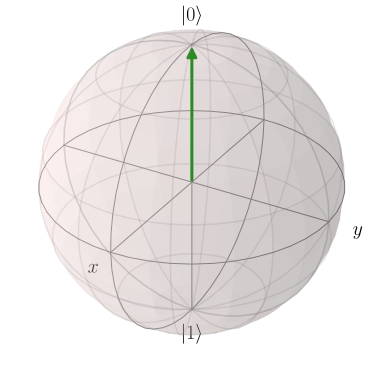

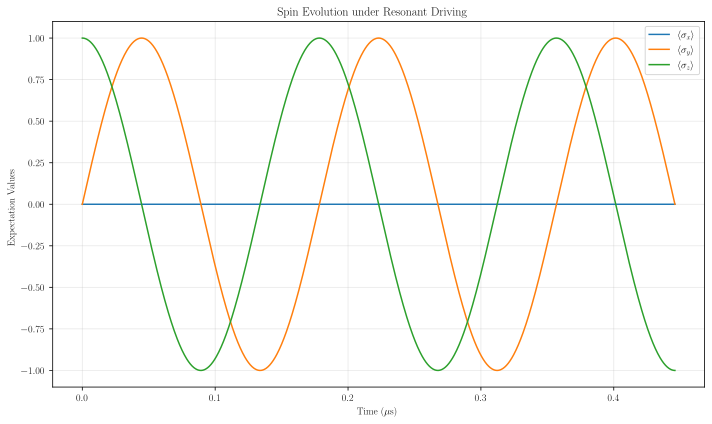

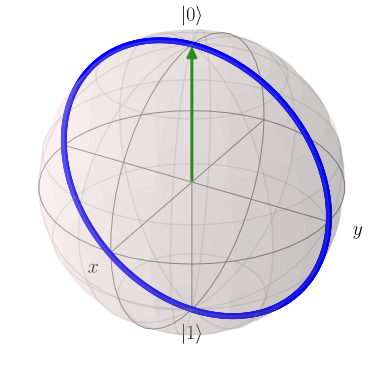

In [5]:
# Resonant driving simulation with H = -Omega/2 * sigmax()
H = -Omega/2 * sigmax()

# Initialize in ground state |0⟩
psi_0 = basis(2, 0)

# Timespan showing several Rabi oscillations
times = np.linspace(0, 5*np.pi/Omega, 1000)  # μs

# Display initial state
b_initial = Bloch()
b_initial.add_states(psi_0)
b_initial.show()

# Solve time evolution with optimized step size
results = sesolve(
    H, psi_0, times, 
    e_ops=[sigmax(), sigmay(), sigmaz()],
    options={"max_step": np.pi/(10*Omega)}  # Adaptive step size based on Rabi frequency
)

# Plot expectation values
fig, ax = plt.subplots(figsize=(10, 6))
for i, label in enumerate([r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
    ax.plot(times, results.expect[i], label=label)

ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel("Expectation Values")
ax.set_title("Spin Evolution under Resonant Driving")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize evolution on Bloch sphere
b_evolution = Bloch()
b_evolution.add_states(psi_0)
b_evolution.add_points([results.expect[i] for i in range(3)])
b_evolution.show()


### **e.  [5 points]**  
For resonant driving ($\omega = \omega_0$): What is the duration for a $\pi$–pulse and for a $\pi/2$–pulse?

---

Pi-pulse duration = 	0.08921 μs
Pi/2-pulse duration = 	0.04460 μs


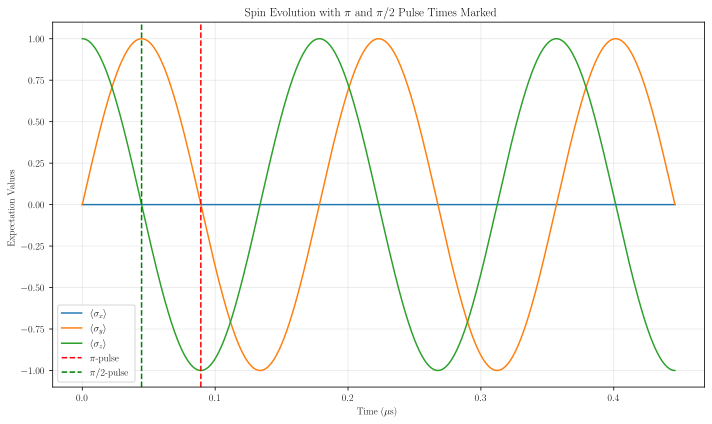

In [6]:
# Calculate π and π/2 pulse durations
pi_pulse_duration = np.pi / Omega
pi_over_2_pulse_duration = pi_pulse_duration / 2

print(f"Pi-pulse duration = \t{pi_pulse_duration:.5f} μs")
print(f"Pi/2-pulse duration = \t{pi_over_2_pulse_duration:.5f} μs")

# Create visualization showing the pulse durations on the Rabi oscillation plot
plt.figure(figsize=(10, 6))

# Plot expectation values
for i, label in enumerate([r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
    plt.plot(times, results.expect[i], label=label)

# Mark pulse durations
plt.axvline(x=pi_pulse_duration, color="r", linestyle="--", label=r"$\pi$-pulse")
plt.axvline(x=pi_over_2_pulse_duration, color="g", linestyle="--", label=r"$\pi/2$-pulse")

# Add labels and formatting
plt.xlabel(r"Time ($\mu$s)")
plt.ylabel("Expectation Values")
plt.title(r"Spin Evolution with $\pi$ and $\pi/2$ Pulse Times Marked")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

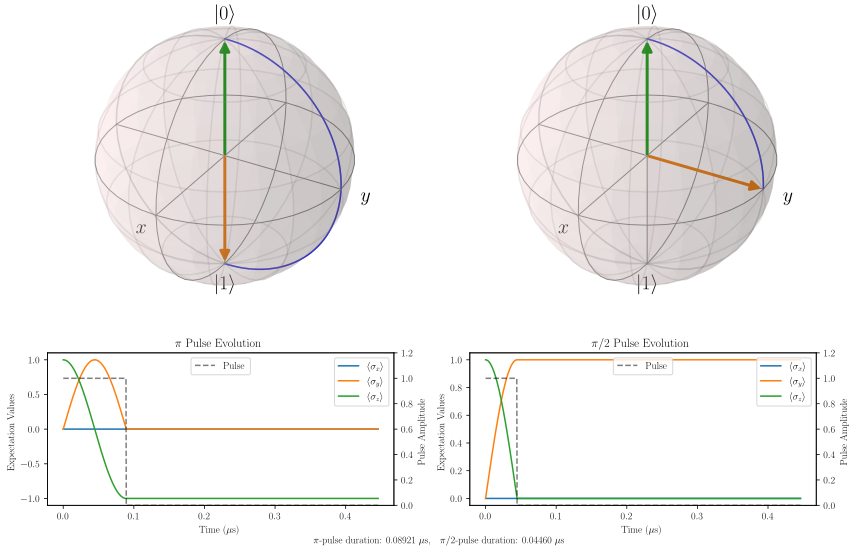

In [7]:
# Define time-dependent coefficients for pi and pi/2 pulses
def pulse_coeff(t, args, duration):
    return 1.0 if t <= duration else 0.0

# Create Hamiltonians for both pulses
pi_pulse_hamiltonian = [[H, lambda t, args: pulse_coeff(t, args, pi_pulse_duration)]]
pi_over_2_pulse_hamiltonian = [[H, lambda t, args: pulse_coeff(t, args, pi_over_2_pulse_duration)]]

# Observable operators
observables = [sigmax(), sigmay(), sigmaz()]

# Time evolution for both pulses
options = {"max_step": pi_over_2_pulse_duration / 10}
results_pi = sesolve(pi_pulse_hamiltonian, psi_0, times, e_ops=observables, options=options)
results_pi_over_2 = sesolve(pi_over_2_pulse_hamiltonian, psi_0, times, e_ops=observables, options=options)

# Generate pulse amplitude data
pi_pulse_amplitude = [pulse_coeff(t, None, pi_pulse_duration) for t in times]
pi_over_2_pulse_amplitude = [pulse_coeff(t, None, pi_over_2_pulse_duration) for t in times]

# Create figure with custom layout
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(3, 2, height_ratios=[2, 1, 0.1])

# Create Bloch spheres for both pulses
def create_bloch_sphere(ax, results, title, target_state=None):
    b = Bloch(axes=ax)
    b.add_states(psi_0)
    points = [results.expect[i] for i in range(3)]
    b.add_points(points, meth="l")
    if target_state is not None:
        b.add_states(target_state)
    b.title = title
    b.render()
    return b

# Pi pulse Bloch sphere
ax1 = fig.add_subplot(gs[0, 0], projection="3d")
create_bloch_sphere(ax1, results_pi, r"$\pi$ Pulse Bloch Sphere", basis(2, 1))

# Pi/2 pulse Bloch sphere
ax2 = fig.add_subplot(gs[0, 1], projection="3d")
create_bloch_sphere(
    ax2, 
    results_pi_over_2, 
    r"$\pi/2$ Pulse Bloch Sphere", 
    (basis(2, 0) + 1j * basis(2, 1)) / np.sqrt(2)
)

# Create evolution plots for both pulses
def create_evolution_plot(ax, results, pulse_amplitude, title):
    ax_pulse = ax.twinx()
    
    for i, label in enumerate([r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
        ax.plot(times, results.expect[i], label=label)
    
    ax_pulse.plot(times, pulse_amplitude, "k--", label="Pulse", alpha=0.5)
    ax_pulse.set_ylim(0, 1.2)
    ax_pulse.set_ylabel("Pulse Amplitude")
    
    ax.set_xlabel(r"Time ($\mu$s)")
    ax.set_ylabel("Expectation Values")
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax_pulse.legend(loc="upper center")

# Pi pulse evolution plot
ax3 = fig.add_subplot(gs[1, 0])
create_evolution_plot(ax3, results_pi, pi_pulse_amplitude, r"$\pi$ Pulse Evolution")

# Pi/2 pulse evolution plot
ax4 = fig.add_subplot(gs[1, 1])
create_evolution_plot(ax4, results_pi_over_2, pi_over_2_pulse_amplitude, r"$\pi/2$ Pulse Evolution")

# Add text with pulse durations
fig.text(
    0.525,
    0.05,
    r"$\pi$-pulse duration: {:.5f} $\mu$s,\quad $\pi/2$-pulse duration: {:.5f} $\mu$s".format(
        pi_pulse_duration, pi_over_2_pulse_duration
    ),
    ha="center",
    fontsize=10,
)

# Adjust layout
plt.tight_layout()
plt.show()


### **f.  [5 points]**  
For resonant driving: Use the Hamiltonian to create the following Ramsey pulse sequence:  $\pi/2 - \tau - \pi/2$ with the interval time $\tau = 25~\mu\mathrm{s}$.  Plot the evolution of the expectation values.

---

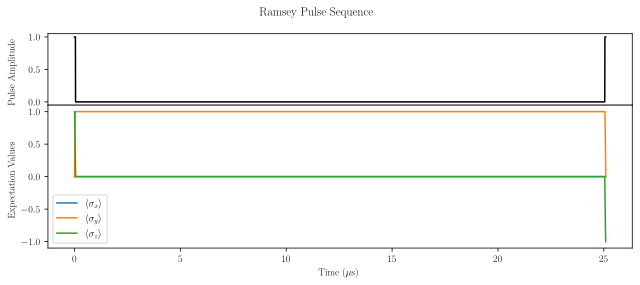

Final X Expectation Value = 0.000
Final Y Expectation Value = -0.000
Final Z Expectation Value = -1.000
Ramsey Sequence Trajectory:


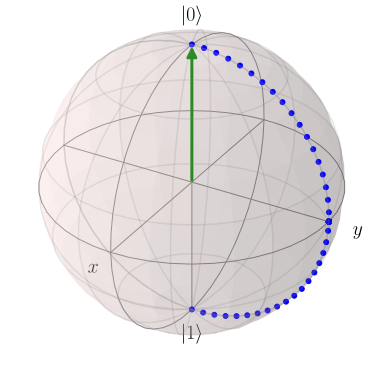

In [8]:
# Implement Ramsey sequence (π/2 - τ - π/2)
tau = 25  # μs (waiting time between pulses)

# Define time span for the entire sequence
total_duration = tau + 2 * pi_over_2_pulse_duration
times = np.linspace(0, total_duration, 10000) 

# Define time-dependent coefficient for Ramsey sequence
def ramsey_pulse(t, args):
    """Return 1 during π/2 pulses, 0 during wait time"""
    return 1 if (t < pi_over_2_pulse_duration or t > tau + pi_over_2_pulse_duration) else 0

# Create Hamiltonian with time-dependent coefficient
H_drive = -Omega/2 * sigmax()
ramsey_hamiltonian = [[H_drive, ramsey_pulse]]

# Solve time evolution with adaptive step size
results = sesolve(
    ramsey_hamiltonian,
    psi_0,
    times,
    e_ops=[sigmax(), sigmay(), sigmaz()],
    options={"max_step": pi_over_2_pulse_duration/10}
)

# Generate pulse amplitude data for plotting
pulse_amplitude = np.array([ramsey_pulse(t, None) for t in times])

# Create figure with shared x-axis
fig, axes = plt.subplots(2, 1, figsize=(9, 4), sharex=True, 
                         gridspec_kw={"height_ratios": [1, 2], "hspace": 0})

# Plot pulse sequence
axes[0].plot(times, pulse_amplitude, "k")
axes[0].set_ylabel("Pulse Amplitude")

# Plot expectation values
for i, label in enumerate([r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
    axes[1].plot(times, results.expect[i], label=label)

# Add labels and formatting
axes[1].set_xlabel(r"Time ($\mu$s)")
axes[1].set_ylabel("Expectation Values")
axes[1].legend()
fig.suptitle("Ramsey Pulse Sequence", y=0.98)
fig.align_ylabels()
plt.tight_layout()
plt.show()

# Print final expectation values
final_expectations = [results.expect[i][-1] for i in range(3)]
for i, label in enumerate(["X", "Y", "Z"]):
    print(f"Final {label} Expectation Value = {final_expectations[i]:.3f}")

# Visualize trajectory on Bloch sphere
b = Bloch()
b.add_states(psi_0)
b.add_points([results.expect[i] for i in range(3)])
print("Ramsey Sequence Trajectory:")
b.show()

### **g.  [5 points]**  
Now consider a random magnetic field generated by a subway train at a distance of 100 $\mathrm{m}$ on the experiment.  To model the random phase shifts that such a random magnetic field will cause, assume a Gaussian current distribution centered around 0 $\mathrm{A}$ with a width (sigma) of 1000 $\mathrm{A}$,  which produces a magnetic field in the $\hat{z}$ direction, effectively from an infinitely long straight wire perpendicular to $\hat{z}$,  in the plane of the experiment at a distance of 100 $\mathrm{m}$.  For a single pulse sequence, this field will be have a fixed current, but will fluctuate from experiment to experiment.  Perform 50 Ramsey experiments with 50 random values from the current distribution. Plot the average spin evolution.

---

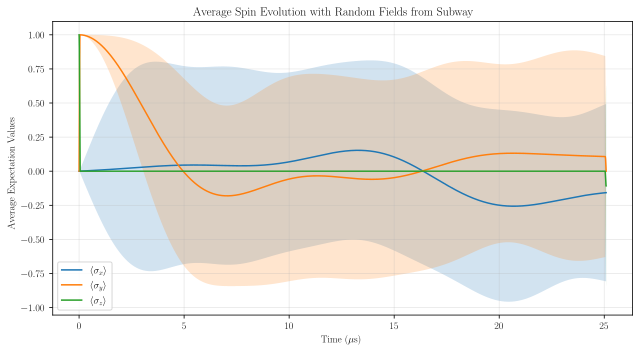

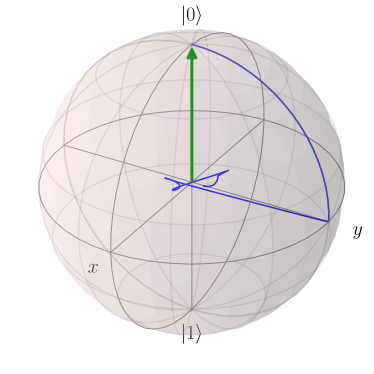

In [9]:
# Model a random magnetic field generated by a subway train
mu_0 = 4 * np.pi * 10**(-7)  # T·m/A, magnetic permeability of free space
tau = 25  # μs, waiting time between pulses

# Define time span for the entire sequence
times = np.linspace(0, tau + 2 * pi_over_2_pulse_duration, 10000)

# Generate 50 random current values from a Gaussian distribution
n_experiments = 50
currents = np.random.normal(0, 1000, n_experiments)  # Currents in Amperes

# Dipole loop parameters
distance = 100  # distance to the spin (m)

# Initialize array to store results
register = np.zeros((n_experiments, 3, len(times)))

# Define time-dependent coefficient for π/2 pulses
def H_coeff_ramsey(t, args):
    return 1 if (t < pi_over_2_pulse_duration or t > tau + pi_over_2_pulse_duration) else 0

# For each random current
for i, current in enumerate(currents):
    # Calculate magnetic field (Tesla)
    B_field_z = mu_0 * current / (2 * np.pi * distance)
    
    # Calculate detuning caused by random field (MHz)
    delta_random = gamma * B_field_z
    
    # Define Hamiltonian components
    H_drive = -Omega/2 * sigmax()
    H_random = -delta_random/2 * sigmaz()
    
    # Construct Hamiltonian
    ramsey_hamiltonian = [
        [H_drive, H_coeff_ramsey],  # Driving during π/2 pulses
        H_random,                   # Always-on random field
    ]

    # Run simulation
    results = sesolve(
        ramsey_hamiltonian,
        psi_0,
        times,
        e_ops=[sigmax(), sigmay(), sigmaz()],
        options={"max_step": pi_over_2_pulse_duration/10},
    )
    
    # Store results
    for j in range(3):
        register[i, j, :] = results.expect[j]

# Calculate statistics
avg_expectation = np.mean(register, axis=0)
std_expectation = np.std(register, axis=0)

# Plot average expectation values with error regions
fig, ax = plt.subplots(figsize=(9, 5))
labels = [r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]

for j in range(3):
    ax.plot(times, avg_expectation[j], label=labels[j])
    ax.fill_between(times, 
                    avg_expectation[j] - std_expectation[j], 
                    avg_expectation[j] + std_expectation[j], 
                    alpha=0.2)

ax.set_xlabel(r"Time ($\mu$s)")
ax.set_ylabel("Average Expectation Values")
ax.set_title("Average Spin Evolution with Random Fields from Subway")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Visualize the trajectory on Bloch sphere
b = Bloch()
b.add_points(avg_expectation, meth="l")
b.add_states(psi_0)
b.show()


### **h.  [5 points]**  
Now pick a few different evolution times $\tau_i$ and study the magnitude of the expectation values at the end of the Ramsey sequence (still with random B-fields from the subway and taking 50 measurements at each time step). Discuss the result.

---

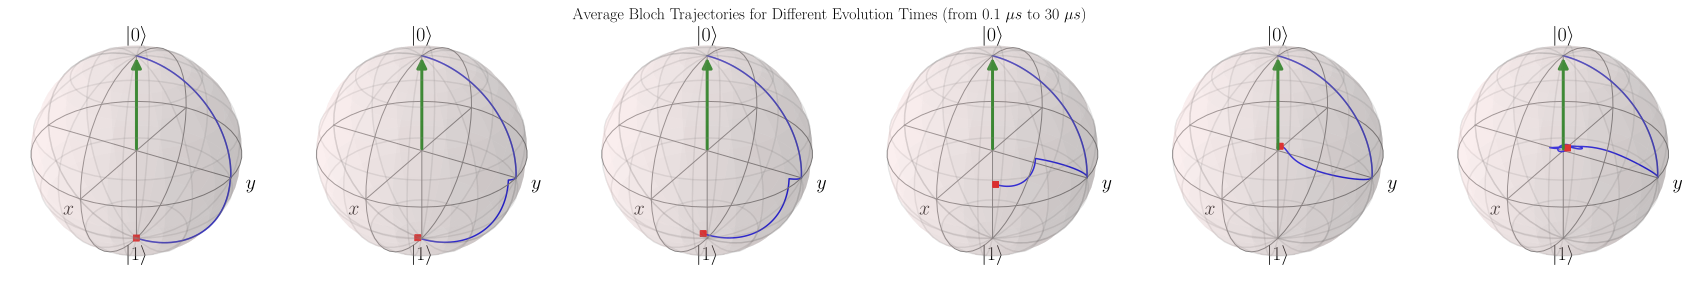

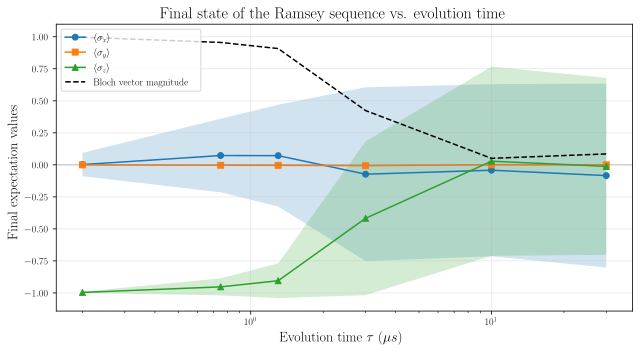

In [10]:
# Define set of evolution times
tau_values = np.array([0.2, 0.75, 1.3, 3, 10, 30])  # μs
num_experiments = 50  # Number of random field experiments per τ value

# Parameters for the random field calculation
mu = 4 * np.pi * 10**(-7)  # magnetic permeability in SI units
R = 1  # radius of coil in meters (unused)
d = 100  # distance in meters

# Arrays to store results
results_dict = {
    'sx': {'final': np.zeros(len(tau_values)), 'std': np.zeros(len(tau_values))}, 
    'sy': {'final': np.zeros(len(tau_values)), 'std': np.zeros(len(tau_values))}, 
    'sz': {'final': np.zeros(len(tau_values)), 'std': np.zeros(len(tau_values))}
}

def run_ramsey_experiment(tau, current):
    """Run a single Ramsey experiment with given evolution time and current."""
    # Calculate B field from random current
    B_field = mu * current / (2 * np.pi * d)  # Tesla
    delta_random = gamma * B_field  # Detuning due to random field (MHz)
    
    # Define Hamiltonians
    H_with_random = -Omega / 2 * sigmax()
    H_z_random = -delta_random / 2 * sigmaz()
    
    # Define time-dependent coefficient for Ramsey sequence
    def H_coeff_ramsey(t, args):
        return 1 if t < pi_over_2_pulse_duration or t > tau + pi_over_2_pulse_duration else 0
    
    # Create time-dependent Hamiltonian
    ramsey_hamiltonian = [[H_with_random, H_coeff_ramsey], H_z_random]
    
    # Define time span for the sequence
    times = np.linspace(0, tau + 2 * pi_over_2_pulse_duration, ceil(1000 * tau))
    
    # Run simulation
    return sesolve(
        ramsey_hamiltonian,
        psi_0,
        times,
        e_ops=[sigmax(), sigmay(), sigmaz()],
        options={"max_step": pi_over_2_pulse_duration / 100},
    )

# Loop over each τ value
fig = plt.figure(figsize=(24, 4))

for i, tau in enumerate(tau_values):
    # Generate random currents
    currents = np.random.normal(0, 1000, num_experiments)  # Amperes
    
    # Arrays to store results for this τ value
    exp_values = {'sx': [], 'sy': [], 'sz': []}
    trajectories = {'sx': [], 'sy': [], 'sz': []}
    
    # Run experiments with different random fields
    for current in currents:
        results = run_ramsey_experiment(tau, current)
        
        # Store final and trajectory values
        for j, key in enumerate(['sx', 'sy', 'sz']):
            exp_values[key].append(results.expect[j][-1])
            trajectories[key].append(results.expect[j])
    
    # Calculate statistics
    for key in ['sx', 'sy', 'sz']:
        results_dict[key]['final'][i] = np.mean(exp_values[key])
        results_dict[key]['std'][i] = np.std(exp_values[key])
    
    # Calculate average trajectories
    avg_trajectory = {key: np.mean(trajectories[key], axis=0) for key in ['sx', 'sy', 'sz']}
    
    # Create Bloch sphere in the appropriate subplot position
    ax = fig.add_subplot(1, 6, i+1, projection='3d')
    b = Bloch(fig=fig, axes=ax)
    
    # Add trajectories and points to Bloch sphere
    b.add_points([avg_trajectory['sx'], avg_trajectory['sy'], avg_trajectory['sz']], meth="l")
    b.add_states(psi_0)
    b.add_points([results_dict['sx']['final'][i], results_dict['sy']['final'][i], 
                 results_dict['sz']['final'][i]], meth="s")
    b.render()

# Adjust layout
plt.tight_layout()
plt.suptitle(r"Average Bloch Trajectories for Different Evolution Times (from 0.1 $\mu s$ to 30 $\mu s$)", 
             fontsize=16, y=0.98)
plt.subplots_adjust(top=0.90)
plt.show()

# Calculate magnitude of the Bloch vector
bloch_magnitude = np.sqrt(results_dict['sx']['final']**2 + 
                         results_dict['sy']['final']**2 + 
                         results_dict['sz']['final']**2)

# Plot the final expectation values
plt.figure(figsize=(9, 5))

for key, marker, label in zip(['sx', 'sy', 'sz'], ['o-', 's-', '^-'], 
                             [r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
    plt.plot(tau_values, results_dict[key]['final'], marker, label=label)
    plt.fill_between(tau_values, 
                     results_dict[key]['final'] - results_dict[key]['std'], 
                     results_dict[key]['final'] + results_dict[key]['std'], 
                     alpha=0.2)

plt.plot(tau_values, bloch_magnitude, "k--", label="Bloch vector magnitude")
plt.xscale("log")
plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel(r"Evolution time $\tau$ ($\mu s$)", fontsize=14)
plt.ylabel("Final expectation values", fontsize=14)
plt.title("Final state of the Ramsey sequence vs. evolution time", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


1. **Ramsey Sequence Setup**  
    The simulation implements a Ramsey-style pulse sequence for a spin-$\tfrac{1}{2}$ system. Initially, the spin is put into a superposition state (via a $\pi/2$ pulse), then allowed to evolve freely under the influence of both a known driving field and a randomly fluctuating magnetic field. Finally, a second $\pi/2$ pulse is applied before measuring the spin expectation values.

2. **Effect of Random Magnetic Fields**  

    - Each experiment draws a random current, which induces a random magnetic field.  
    - This random field shifts the spin’s resonance frequency (a “detuning”), causing the spin to accumulate a random phase relative to the ideal driving field.  
    - When averaged over many experiments with different random fields, these small phase shifts add up to broaden the distribution of final spin states (decoherence).

3. **Dephasing Over Longer Evolution Times $\tau$**  
   
    - During the free evolution interval $\tau$, the spin “accumulates” phase error due to the random detuning.  
    - For short $\tau$, the spin does not evolve long enough to incur a large random phase; hence, the ensemble-averaged Bloch vector remains relatively coherent (longer Bloch vector length, more pronounced $z$-component).  
    - As $\tau$ increases, the random phase accumulates more significantly. Different random fields cause different phases to build up, causing the spins to “fan out” around the Bloch sphere.  
    - The net result is a loss of coherence in the ensemble average: the Bloch vector shrinks in magnitude and its $z$-component in particular decays.

4. **Observable Consequences in the Plots**  
   
    - **Bloch Sphere Trajectories**: The trajectory of the averaged Bloch vector becomes more diffuse and the final point moves closer to the equatorial plane (lower $z$-value) for larger $\tau$.  
    - **Expectation Values**: In the final plots of $\langle \sigma_x \rangle$, $\langle \sigma_y \rangle$, $\langle \sigma_z \rangle$, one sees a larger spread (standard deviation) and an overall decrease in $\langle \sigma_z \rangle$ as $\tau$ grows. The dashed line tracking the Bloch vector magnitude also decreases with longer $\tau$, reflecting the net dephasing.

5. **Physical Interpretation**  
   
    - The “decay” of the Bloch vector and its $z$-component signifies loss of phase coherence from the ensemble’s perspective.  
    - Longer evolution times in a noisy environment naturally lead to more random phase accumulation and therefore stronger dephasing.  
    - This behavior is consistent with fundamental decoherence mechanisms in quantum systems: the longer you let the system evolve in a noisy or inhomogeneous field, the more coherence is lost.

In summary, increasing $\tau$ exacerbates the random field’s impact. The spins acquire a wider range of relative phases, so the ensemble-averaged Bloch vector shrinks and its $z$-component decays, illustrating the hallmark of decoherence in a Ramsey experiment.

### **i.  [5 points]**  
Perform a spin echo experiment $\pi/2 - \tau - \pi - \tau - \pi/2$ with the randomly fluctuating field from above (50 measurements).  What is the behavior of the final expectation values as a function of $\tau$? Discuss the result.

---

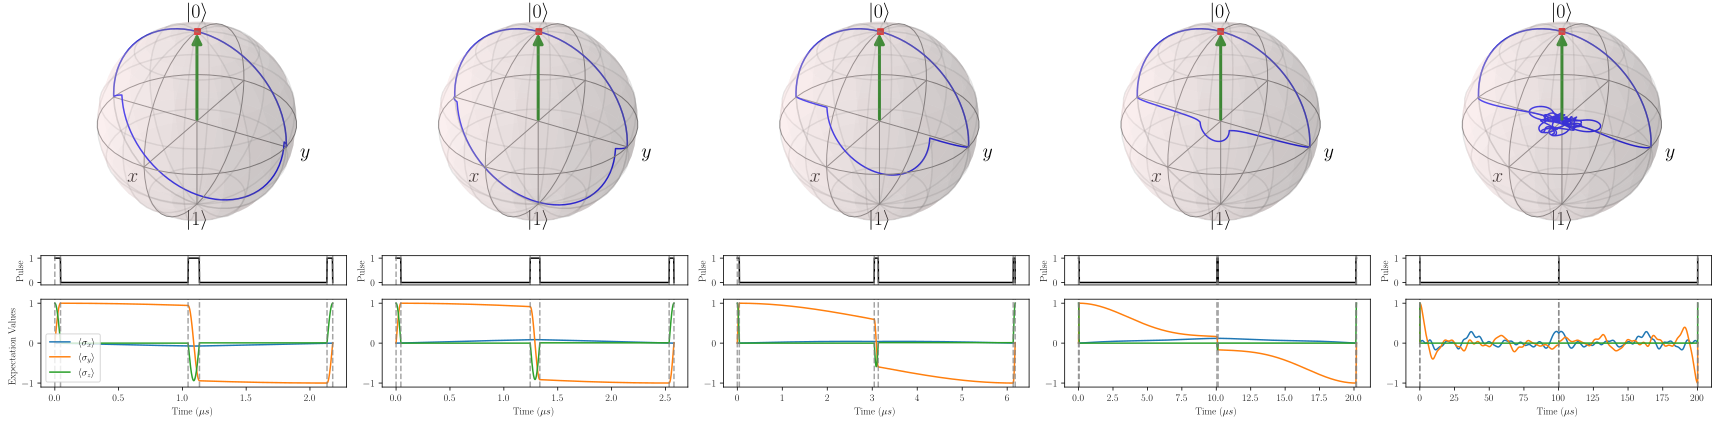

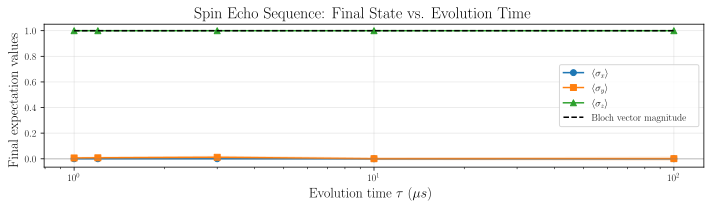

In [11]:
# This cell will take ~2 min to run
# Implement a spin echo sequence (π/2 - τ - π - τ - π/2)

# Define experimental parameters
tau_values = np.array([1, 1.2,  3, 10, 100])  # μs
num_experiments = 50  # Number of random field experiments per τ value
resolution = 1000

# Initialize result arrays
result_shape = len(tau_values)
final_expectation = {
    'x': np.zeros(result_shape),
    'y': np.zeros(result_shape),
    'z': np.zeros(result_shape)
}
std_expectation = {
    'x': np.zeros(result_shape),
    'y': np.zeros(result_shape),
    'z': np.zeros(result_shape)
}

# Parameters for the random field
mu = 4 * np.pi * 10**(-7)  # magnetic permeability in SI units
R, d = 1, 100  # radius (m), distance (m)

# Create figure with custom layout
fig = plt.figure(figsize=(24, 6))
gs = plt.GridSpec(3, len(tau_values), height_ratios=[4, 0.5, 1.5])

# Define time-dependent coefficient for Spin Echo sequence
def H_coeff_spin_echo(t, args):
    """Time-dependent control for the spin echo sequence."""
    if t < pi_over_2_pulse_duration or (
        pi_over_2_pulse_duration + 2*tau + pi_pulse_duration <= t < 2*pi_over_2_pulse_duration + 2*tau + pi_pulse_duration
    ):
        return 1  # π/2 pulses
    elif pi_over_2_pulse_duration + tau <= t < pi_over_2_pulse_duration + tau + pi_pulse_duration:
        return 1  # π pulse
    return 0  # Waiting periods

# Loop over each τ value
for i, tau in enumerate(tau_values):
    # Initialize experiment storage
    experiment_results = {
        'x': np.zeros(num_experiments),
        'y': np.zeros(num_experiments),
        'z': np.zeros(num_experiments)
    }
    all_trajectories = {
        'x': [],
        'y': [],
        'z': []
    }

    # Calculate total sequence duration and time points
    total_time = 2 * pi_over_2_pulse_duration + pi_pulse_duration + 2 * tau
    times = np.linspace(0, total_time, ceil(resolution * tau))  # μs

    # Calculate pulse shape for plotting
    H_coeff_values = np.array([H_coeff_spin_echo(t, None) for t in times])
    
    # Generate random currents
    currents = np.random.normal(0, resolution, num_experiments)  # Amperes
    
    # Run experiments with different random fields
    for j, current in enumerate(currents):
        # Calculate B field and detuning from random current
        B_field = mu * current / (2 * np.pi * d)  # Tesla
        delta_random = gamma * B_field  # Detuning due to random field (MHz)

        # Define Hamiltonian with random field contribution
        H_with_random = -Omega / 2 * sigmax()
        H_z_random = -delta_random / 2 * sigmaz()  # Random field contribution
        
        spin_echo_hamiltonian = [
            [H_with_random, H_coeff_spin_echo],  # Driving terms
            H_z_random,  # Always-on random field
        ]

        # Run simulation
        results = sesolve(
            spin_echo_hamiltonian, psi_0, times, 
            e_ops=[sigmax(), sigmay(), sigmaz()],
            options={"max_step": pi_over_2_pulse_duration/10}
        )
        
        # Store final expectation values
        for idx, key in enumerate(['x', 'y', 'z']):
            experiment_results[key][j] = results.expect[idx][-1]
            all_trajectories[key].append(results.expect[idx])

    # Calculate statistics
    for key in ['x', 'y', 'z']:
        final_expectation[key][i] = np.mean(experiment_results[key])
        std_expectation[key][i] = np.std(experiment_results[key])
    
    # Calculate average trajectories
    avg_trajectories = {key: np.mean(all_trajectories[key], axis=0) for key in ['x', 'y', 'z']}

    # Plot Bloch sphere in upper row
    ax_bloch = plt.subplot(gs[0, i], projection='3d')
    bloch = Bloch(fig=fig, axes=ax_bloch)
    bloch.add_states(psi_0)
    bloch.point_size = [30]
    
    # Add trajectory points to Bloch sphere
    bloch.add_points([avg_trajectories['x'], avg_trajectories['y'], avg_trajectories['z']], meth='l')
    bloch.add_points([final_expectation['x'][i], final_expectation['y'][i], final_expectation['z'][i]], meth='s')
    bloch.title = rf"Average Spin Echo: $\tau$ = {tau} $\mu s$"
    bloch.render()
    
    # Plot pulse shape
    ax_pulse = plt.subplot(gs[1, i])
    ax_pulse.plot(times, H_coeff_values, 'k')
    ax_pulse.set_ylabel("Pulse")
    ax_pulse.set_ylim(-0.1, 1.1)
    ax_pulse.set_xticks([])
    
    # Plot expectation values
    ax_expect = plt.subplot(gs[2, i])
    ax_expect.plot(times, avg_trajectories['x'], label=r'$\langle\sigma_x\rangle$')
    ax_expect.plot(times, avg_trajectories['y'], label=r'$\langle\sigma_y\rangle$')
    ax_expect.plot(times, avg_trajectories['z'], label=r'$\langle\sigma_z\rangle$')
    ax_expect.set_xlabel(r"Time ($\mu s$)")
    
    if i == 0:
        ax_expect.set_ylabel('Expectation Values')
        ax_expect.legend()
    
    # Add vertical lines to mark sequence segments
    segment_times = [
        0, pi_over_2_pulse_duration, 
        pi_over_2_pulse_duration + tau,
        pi_over_2_pulse_duration + tau + pi_pulse_duration,
        pi_over_2_pulse_duration + tau + pi_pulse_duration + tau,
        pi_over_2_pulse_duration + tau + pi_pulse_duration + tau + pi_over_2_pulse_duration
    ]

    for t in segment_times:
        ax_pulse.axvline(x=t, color='gray', linestyle='--', alpha=0.7)
        ax_expect.axvline(x=t, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Calculate magnitude of the Bloch vector for each τ
bloch_magnitude = np.sqrt(
    final_expectation['x']**2 + 
    final_expectation['y']**2 + 
    final_expectation['z']**2
)

# Plot the final expectation values as a function of τ
plt.figure(figsize=(10, 3))

# Plot each component with error regions
for key, marker, label in zip(['x', 'y', 'z'], ['o-', 's-', '^-'], 
                             [r"$\langle\sigma_x\rangle$", r"$\langle\sigma_y\rangle$", r"$\langle\sigma_z\rangle$"]):
    plt.plot(tau_values, final_expectation[key], marker, label=label)
    plt.fill_between(
        tau_values, 
        final_expectation[key] - std_expectation[key], 
        final_expectation[key] + std_expectation[key], 
        alpha=0.2
    )

plt.plot(tau_values, bloch_magnitude, "k--", label="Bloch vector magnitude")

plt.xscale("log")
plt.axhline(y=0, color="gray", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xlabel(r"Evolution time $\tau$ ($\mu s$)", fontsize=14)
plt.ylabel("Final expectation values", fontsize=14)
plt.title("Spin Echo Sequence: Final State vs. Evolution Time", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()


The revival phenomenon observed in the spin echo experiment can be explained by how the $\pi$ pulse in the middle of the sequence counteracts the dephasing caused by random magnetic field fluctuations:

1. **Initial state preparation**: The first $\pi/2$ pulse rotates the state from $|0\rangle$ to the equatorial plane of the Bloch sphere.

2. **First dephasing period**: During the first waiting period $\tau$, random magnetic field fluctuations cause qubits to precess at different rates, leading to phase dispersion.

3. **Refocusing mechanism**: The $\pi$ pulse in the middle of the sequence flips the state to the opposite side of the equatorial plane. This crucial step means that:

    - Qubits that were precessing faster now lag behind
    - Qubits that were lagging now move ahead
    - The phase accumulation during the second waiting period $\tau$ cancels the phase accumulated during the first period

4. **Refocused state**: After the second waiting period $\tau$, the qubits realign, effectively undoing the dephasing caused by static or slowly varying field inhomogeneities.

5. **Final measurement**: The final $\pi/2$ pulse rotates the refocused state for measurement.

The effectiveness of this revival depends on how static the random fields are during the total experiment duration. If the field fluctuations remain relatively constant throughout both $\tau$ periods, the refocusing works well even for longer intervals. As we increase $\tau$, the revival becomes less perfect because:

- Field fluctuations may not remain constant over longer timescales
- Other decoherence mechanisms (like $T_1$ relaxation) that cannot be reversed by the $\pi$ pulse become more significant

This technique is fundamentally different from the Ramsey sequence ($\pi/2 - \tau - \pi/2$), which is sensitive to field fluctuations and shows increased decoherence with longer $\tau$ values.


## **Problem 2-2 [10 points]**  

**Generating entanglement.**

Consider a chloroform molecule ($\mathrm{CHCl}_3$) from Chuang et al., Nature **393**, 143 (1998).  This problem may be done either by hand or implemented in QuTiP, as you prefer.

### **a. [5 points]**  
Formulate the Hamiltonian in an appropriate rotating frame for $^1\mathrm{H}$ and $^{13}\mathrm{C}$ with values from the paper (including the exchange coupling).

---

**1. Lab‐Frame Hamiltonian (With Drive)**

In the **lab frame**, the total Hamiltonian for two spins $A$ (proton) and $B$ (carbon) subject to a static magnetic field $\mathbf{B}_0 \parallel \hat{z}$ and time‐dependent RF fields can be written as:

$$
\hat{H}_{\mathrm{lab}}(t)
=
-\,\omega_A\,\hat{I}_{zA}
-\,\omega_B\,\hat{I}_{zB}
\;+\;
2\pi\,J\,\hat{I}_{zA}\hat{I}_{zB}
\;+\;
\hat{H}_{\mathrm{drive}}(t).
$$

Here,

1. $\omega_A = 2\pi\,\nu_A$ and $\omega_B = 2\pi\,\nu_B$ are the Larmor (precession) frequencies for proton ($\nu_A \approx 500\,\mathrm{MHz}$) and carbon ($\nu_B \approx 125\,\mathrm{MHz}$), respectively.
2. $J \approx 215\,\mathrm{Hz}$ is the scalar (exchange) coupling constant.
3. $\hat{I}_{zA}$ and $\hat{I}_{zB}$ are the $z$‐components of the spin operators for each nucleus.
4. $\hat{H}_{\mathrm{drive}}(t)$ represents the externally applied RF fields (pulses). For example, if you selectively drive spin $A$ near $\omega_A$, a typical lab‐frame form is
   
    $$
     \hat{H}_{\mathrm{drive}}(t)
     \;=\;
     \Omega_A(t)\,\cos\Bigl(\omega_{dA}\,t + \phi_A\Bigr)\,\hat{I}_{xA}
     \;+\;
     \Omega_B(t)\,\cos\Bigl(\omega_{dB}\,t + \phi_B\Bigr)\,\hat{I}_{xB},
    $$

    where $\omega_{dA}\approx \omega_A$ and $\omega_{dB}\approx \omega_B$ are the drive frequencies, $\Omega_{A,B}(t)$ are the (time‐dependent) Rabi amplitudes, and $\phi_{A,B}$ are phases.

---

**2. Moving to the Rotating Frame(s)**

To eliminate the large Zeeman terms, one typically transforms to a **double rotating frame** at frequencies $\omega_{dA}$ and $\omega_{dB}$.  Define the unitary operator:

$$
U(t)
\;=\;
\exp\Bigl[\,+\,i\,\omega_{dA}\,\hat{I}_{zA}\,t\Bigr]
\;\exp\Bigl[\,+\,i\,\omega_{dB}\,\hat{I}_{zB}\,t\Bigr].
$$

The Hamiltonian in the rotating frame is then

$$
\hat{H}_{\mathrm{rot}}(t)
\;=\;
U^\dagger(t)\,\hat{H}_{\mathrm{lab}}(t)\,U(t)
\;-\;
i\,U^\dagger(t)\,\frac{d}{dt}U(t).
$$

**2.1. Zeeman Terms**

- The proton Zeeman term $-\,\omega_A\,\hat{I}_{zA}$ becomes

    $$
    -\,\omega_A\,\hat{I}_{zA} 
    \;\;\longrightarrow\;\;
    -\,\Bigl(\omega_A - \omega_{dA}\Bigr)\,\hat{I}_{zA}
    \;=\;
    -\,\Delta_A\,\hat{I}_{zA},
    $$

    where $\Delta_A = \omega_A - \omega_{dA}$ is the proton **detuning**.

- The carbon Zeeman term $-\,\omega_B\,\hat{I}_{zB}$ becomes

    $$
    -\,\omega_B\,\hat{I}_{zB}
    \;\;\longrightarrow\;\;
    -\,\Bigl(\omega_B - \omega_{dB}\Bigr)\,\hat{I}_{zB}
    \;=\;
    -\,\Delta_B\,\hat{I}_{zB},
    $$

    where $\Delta_B = \omega_B - \omega_{dB}$.

**2.2. Scalar Coupling Term**

The coupling $2\pi\,J\,\hat{I}_{zA}\hat{I}_{zB}$ commutes with rotations about $z$, so it is **unchanged** in the rotating frame:

$$
2\pi\,J\,\hat{I}_{zA}\hat{I}_{zB}
\;\;\longrightarrow\;\;
2\pi\,J\,\hat{I}_{zA}\hat{I}_{zB}.
$$

**2.3. Drive Terms (Rotating Wave Approximation)**

Under the rotating wave approximation (RWA), each drive near $\omega_{dA}$ or $\omega_{dB}$ transforms to a **near‐constant** term in $I_x$ and/or $I_y$.  For instance, for the proton drive:

$$
\Omega_A(t)\,\cos\Bigl(\omega_{dA}\,t + \phi_A\Bigr)\,\hat{I}_{xA}
\;\;\longrightarrow\;\;
\frac{\Omega_A(t)}{2}\,\Bigl[\cos(\phi_A)\,\hat{I}_{xA} + \sin(\phi_A)\,\hat{I}_{yA}\Bigr].
$$

An analogous expression holds for the carbon drive.  (The factor of $1/2$ arises from dropping the fast‐oscillating counter‐rotating term in the RWA.)

---

**3. Final Rotating‐Frame Hamiltonian**

Putting it all together, the **time‐dependent rotating‐frame Hamiltonian** (assuming both spins can be driven) typically looks like:

$$
\boxed{
\begin{aligned}
\hat{H}_{\mathrm{rot}}(t)
\;=\;&
-\,\Delta_A\,\hat{I}_{zA}
\;-\;\Delta_B\,\hat{I}_{zB}
\;+\;
2\pi\,J\,\hat{I}_{zA}\,\hat{I}_{zB}
\\
&\quad+\;
\frac{\Omega_A(t)}{2}\,\Bigl[\cos(\phi_A)\,\hat{I}_{xA} \;+\; \sin(\phi_A)\,\hat{I}_{yA}\Bigr]
\\
&\quad+\;
\frac{\Omega_B(t)}{2}\,\Bigl[\cos(\phi_B)\,\hat{I}_{xB} \;+\; \sin(\phi_B)\,\hat{I}_{yB}\Bigr].
\end{aligned}
}
$$

Here:

- $\Delta_A = \omega_A - \omega_{dA}$ and $\Delta_B = \omega_B - \omega_{dB}$ are the detunings.
- $\Omega_A(t)$ and $\Omega_B(t)$ are the drive amplitudes (Rabi frequencies) for each spin’s RF pulse.
- $\phi_A$ and $\phi_B$ are the drive phases.
- $2\pi\,J\,\hat{I}_{zA}\hat{I}_{zB}$ remains the same as in the lab frame.

If you **only** drive one spin at a time (e.g.\ proton at $\omega_{dA} \approx \omega_A$), then the carbon drive terms vanish and $\Delta_B = \omega_B - \omega_{dB}$ might be large (off‐resonance).  In that simpler case, the rotating‐frame Hamiltonian reduces accordingly.

---

### **b. [5 points]**  
Assume that you can initialize both spins in the up-state. Specify a pulse sequence with which you can create the Bell state $\lvert \psi^+ \rangle = \left( \lvert 00 \rangle + \lvert 11 \rangle \right)/\sqrt{2}.$ You may assume that you can switch the exchange coupling $J$ on and off  (in reality this would be done with refocusing pulses).

---

1. First, apply 

    $$
    R_y(\pi/2) = \exp(-i \frac{\pi}{4} \hat{\sigma}_y) = \frac{1}{\sqrt2} (\hat{I} - i \hat{\sigma}_y)
    $$

    to both spins. This rotates both states from $\ket0$ to $\ket{+}$, and the overall state becomes:
    
    $$
    \ket{++} = \frac{1}{2} (\ket0 + \ket1) \otimes (\ket0 + \ket1) = \frac{1}{2} (\ket{00} + \ket{01} + \ket{10} + \ket{11}).
    $$

2. Next, build up entanglement with $\mathcal{U}_{ZZ}(t) = e^{-i \pi J t \hat{\sigma}_z \otimes \hat{\sigma}_z/2}$, and set the pulse time

    $$
    t = \frac{1}{2J}.
    $$

    , which gives:

    $$
    \mathcal{U}_{ZZ}(\frac{1}{2J}) = e^{-i \frac{\pi}{4} } \begin{pmatrix}
        1 & 0 & 0 & 0 \\
        0 & i & 0 & 0 \\
        0 & 0 & i & 0 \\
        0 & 0 & 0 & 1
    \end{pmatrix}.
    $$

    The state evolves as:

    $$
    \ket{++} \xrightarrow{\mathcal{U}_{ZZ}(\frac{1}{2J})} \frac{1}{2} (\ket{00} + i\ket{01} + i\ket{10} + \ket{11}) = \frac{\ket{0}}{2} \otimes (\ket0 + i\ket1) + \frac{\ket{1}}{2} \otimes (i\ket0 + \ket1).
    $$

3. Finally, apply
   
    $$
    R_x(\pi/2) = \exp(-i \frac{\pi}{4} \hat{\sigma}_x) = \frac{1}{\sqrt2} (\hat{I} - i \hat{\sigma}_x)
    = \frac{1}{\sqrt{2}} \begin{pmatrix}
        1 & -i \\
        -i & 1
    \end{pmatrix}
    $$

    to the second spin. Then the state evolves as:

    $$
    \frac{\ket{0}}{2} \otimes (\ket0 + i\ket1) + \frac{\ket{1}}{2} \otimes (i\ket0 + \ket1) 
    \xrightarrow{R_x(\pi/2)} 
    \frac{\ket{0}}{2} \otimes \sqrt{2} \ket{0} + \frac{\ket{1}}{2} \otimes \sqrt{2} \ket{1}
    = \frac{1}{\sqrt{2}} \left( \ket{00} + \ket{11} \right).
    $$

In [12]:
# Verification

def Rx(theta):
    return (-1j * theta/2 * sigmax()).expm()

def Ry(theta):
    return (-1j * theta/2 * sigmay()).expm()

def U_ZZ(theta):
    zz_term = tensor(sigmaz(), sigmaz())
    
    return (-1j * theta/2 * zz_term).expm()

# Initialize the state |00⟩
psi_0 = tensor(basis(2, 0), basis(2, 0))
print(f"Initial state: {psi_0}")

# Step 1: Apply Ry(π/2) to both qubits
ry_pi_2 = Ry(np.pi/2)
psi_1 = tensor(ry_pi_2, ry_pi_2) * psi_0
print(f"After Ry(π/2) on both qubits: {psi_1}")

# Step 2: Apply ZZ coupling with θ = π/2 (equivalent to t = 1/2J)
psi_2 = U_ZZ(np.pi/2) * psi_1
print(f"After ZZ coupling: {psi_2}")

# Step 3: Apply Rx(π/2) to the second qubit only
rx_pi_2 = Rx(np.pi/2)
psi_3 = tensor(qeye(2), rx_pi_2) * psi_2
print(f"Final state: {psi_3}")

# Create the expected Bell state |ψ+⟩ = (|00⟩ + |11⟩)/√2
bell_state = (tensor(basis(2, 0), basis(2, 0)) + tensor(basis(2, 1), basis(2, 1))).unit()
print(f"Expected Bell state: {bell_state}")

# Calculate fidelity to Bell state
fidelity_to_bell = fidelity(psi_3, bell_state)
print(f"Fidelity to Bell state: {fidelity_to_bell}")

Initial state: Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]]
After Ry(π/2) on both qubits: Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.5]
 [0.5]
 [0.5]
 [0.5]]
After ZZ coupling: Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.35355339-0.35355339j]
 [0.35355339+0.35355339j]
 [0.35355339+0.35355339j]
 [0.35355339-0.35355339j]]
Final state: Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[5.00000000e-01-5.00000000e-01j]
 [0.00000000e+00-5.55111512e-17j]
 [1.66533454e-16+1.38777878e-16j]
 [5.00000000e-01-5.00000000e-01j]]
Expected Bell state: Quantum object: dims=[[2, 2], [1, 1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[0.70710678]
 [0.        ]
 [0.        ]
 [0.70710678]]
Fidelity to Bell state: 1.0


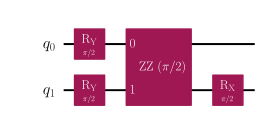

In [13]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate

qc = QuantumCircuit(2)

# Step 1: Apply Ry(π/2) to both qubits
qc.ry(np.pi/2, 0)
qc.ry(np.pi/2, 1)

# Step 2: Apply ZZ interaction with θ = π/2 (equivalent to t = 1/2J)
zz_matrix = np.array([
    [np.exp(-1j * np.pi/4), 0, 0, 0],
    [0, np.exp(1j * np.pi/4), 0, 0],
    [0, 0, np.exp(1j * np.pi/4), 0],
    [0, 0, 0, np.exp(-1j * np.pi/4)]
])
zz_gate = UnitaryGate(zz_matrix, label=r"ZZ ($\pi$/2)")
qc.append(zz_gate, [0, 1])

# Step 3: Apply Rx(π/2) to the second qubit only
qc.rx(np.pi/2, 1)

qc.draw('mpl', style={'dpi': 300})